# **Variant Classification and Interpretability of SNPs using CNN-LSTM with Custom SmoothGrad on 1D Genomic Sequences**

#**Introduction**

This project focuses on building a **deep learning pipeline** to classify **single nucleotide polymorphisms (SNPs)** as **Pathogenic** or **Benign** based on their surrounding DNA sequence context. It goes beyond classification by implementing a custom **SmoothGrad-based interpretability framework** to highlight which base positions are most influential in the model's prediction.

The key objectives of this project are:

* To develop a dual-input neural network architecture that accepts both the reference and alternate DNA sequences of each SNP.

* To train the model using curated variant data sourced from ClinVar and Ensembl, with position-specific feature engineering.

* To apply SmoothGrad, a gradient-based interpretability technique, on the output of the embedding layers in order to:

* Visualize the model's sensitivity to each base.

* Detect whether the model correctly identifies the alternate allele position as important.

* Interpret the learned features in a biologically meaningful way.

This project is an initial attempt to explore how deep learning models, particularly **CNN-LSTM architectures**, can be used to classify SNPs based on their surrounding **DNA** sequence. In addition to building a classifier, a custom implementation of the **SmoothGrad technique** was used to gain insight into which base positions influence the model's predictions the most.

We can furthur improve its performance by fine tuning its **hyperparameters** to get more accurcate results.

#**Problem Statement**

I have taken a dataset with labeled **SNPs (Single Nucleotide Polymorphisms)** from **ClinVar**, the goal is to build a model that can classify each variant as either:

* **Pathogenic(disease-causing)**

* **Benign(harmless)**

I have created this project keeping in mind that identifying pathogenic variants from DNA sequences is a critical part of understanding genetic diseases. These changes may be very subtle involving just one base in a long sequence and might be hard to detect through manual analysis or traditional tools.

To make the model more transparent and interpretable, I have also implemented a custom version of **SmoothGrad** to highlight which base positions influenced the model’s prediction. This can help us verify whether the model is truly learning meaningful **biological patterns** such as the actual position of the variant and could potentially assist researchers or clinicians as a second layer of insight in the future.

# **Dataset**

The dataset used in this project is sourced from **ClinVar** ,a publicly available database that aggregates information about genomic variation and its relationship to human health.

This dataset contains over 700,000 labeled **SNPs(Single Nucleotide Polymorphism)** samples, spanning across all **23 human chromosomes**. Each sample includes the **chromosomal location**, **reference allele**, **alternate allele**, and a **clinical significance** label typically annotated as either **Pathogenic** or **Benign**.

**CLinVar** Dataset Link:
Website: https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/

For each **SNP**, I used the **Ensembl REST API** to retrieve a **150-base pair DNA sequence window** for the specific chromosome number surrounding the variant (75 bases upstream and downstream).

Two versions of each sequence were created:
* The **reference sequence**, containing the original allele at the SNP position.
* The **alternate sequence**, where the variant allele replaces the reference.

This dual representation allows the model to compare the effect of the alternate allele in context and learn how subtle changes in sequence influence pathogenicity of the SNPs.

The dataset was preprocessed to ensure:
* Some SNPs that were labelled with likely/unlikely pathogenic/bening are removed from the dataset.
* Class imbalance is mitigated using **SMOTE(Synthetic Minority Oversampling Technique)** and **Random UnderSampling** and I have compared the metric we got for both techniques.


# **Model Inspiration**

 I have taken the model inspiration from the research paper titled
 "**Analysis of DNA Sequence Classification Using CNN and Hybrid Models**"

 The research paper focuses how **CNN** based models can perform better for feature extraction and **RNN** can be used to learn dependencies of the DNA sequence.

 The **cutsom CNN-LSTM dual input model architecture** is not used anywhere in the research paper, this is my logical way of approaching the solution. As I thought that the **1D CNN filters** can be used to extract features from the DNA sequcnes and **LSTM layers** can learn long term dependencies in the DNA sequcnes.

This setup allows the model to compare the biological effect of sequence changes directly, which is especially meaningful in SNP classification tasks where the difference may be only a single base.

 **Research Paper**: https://pmc.ncbi.nlm.nih.gov/articles/PMC8285202/

#Installing Necessary Libraries and Dataset Download

I have actually used **pyfaidx** to work on fasta files for **GRch38** chromosoe sequence files.

In [ ]:
!pip install pyfaidx

Installing imbalanced-leaern to use **SMOTE** and **RandomUnderSampler** as I will be using them.

In [ ]:
!pip install imbalanced-learn

Downloading the variant_summary.txt file from the download link: https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz

**Dataset Source:**
The variant data used in this project was obtained from **ClinVar** (https://www.ncbi.nlm.nih.gov/clinvar/), a public archive of reports on the relationships among human genetic variants and phenotypes, with supporting evidence. It provides clinically curated annotations including clinical significance (benign/pathogenic), which were used as labels for training the classification model.




Here I have dowloaded the dataset using wget.

In [ ]:
!wget https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz

--2025-07-23 15:00:23--  https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.31, 130.14.250.10, 130.14.250.11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381718256 (364M) [application/x-gzip]
Saving to: ‘variant_summary.txt.gz’

variant_summary.txt 100%[===================>] 364.03M  22.1MB/s    in 7.5s    

2025-07-23 15:00:31 (48.6 MB/s) - ‘variant_summary.txt.gz’ saved [381718256/381718256]



#Data Preprocessing

**Unzipping the downloaded file**

Unzipping the **.gz** file so that python can read the text file.

In [ ]:
!gunzip variant_summary.txt.gz

Printing the first few lines of the text file.

Here we can see that the dataset has many features or columns but not all of them are useful to me so I removed most of them and kempt some important columns later in this notebook.


In [ ]:
c=0
with open("variant_summary.txt") as f:
  for line in f:
    print(line)
    c=c+1
    if c==10:
      break


#AlleleID	Type	Name	GeneID	GeneSymbol	HGNC_ID	ClinicalSignificance	ClinSigSimple	LastEvaluated	RS# (dbSNP)	nsv/esv (dbVar)	RCVaccession	PhenotypeIDS	PhenotypeList	Origin	OriginSimple	Assembly	ChromosomeAccession	Chromosome	Start	Stop	ReferenceAllele	AlternateAllele	Cytogenetic	ReviewStatus	NumberSubmitters	Guidelines	TestedInGTR	OtherIDs	SubmitterCategories	VariationID	PositionVCF	ReferenceAlleleVCF	AlternateAlleleVCF	SomaticClinicalImpact	SomaticClinicalImpactLastEvaluated	ReviewStatusClinicalImpact	Oncogenicity	OncogenicityLastEvaluated	ReviewStatusOncogenicity	SCVsForAggregateGermlineClassification	SCVsForAggregateSomaticClinicalImpact	SCVsForAggregateOncogenicityClassification

15041	Indel	NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTAACTGTAAA (p.Arg27_Ile28delinsLeuLeuTer)	9907	AP5Z1	HGNC:22197	Pathogenic/Likely pathogenic	1	Dec 17, 2024	397704705	-	RCV000000012|RCV005255549|RCV004998069	MONDO:MONDO:0013342,MedGen:C3150901,OMIM:613647,Orphanet:306511||MedGen:C3661900	Hereditary sp

**Due to memory limitations on Google Colab, reading the entire ClinVar dataset at once was causing RAM crashes. To handle this, I limited the dataset to the first 700,000 rows, which still provides a large and diverse sample across all chromosomes.**



```
df=pd.read_csv("variant_summary.txt", sep="\t",low_memory=False,nrows=700000)
```
* **nrows=700000** ensures only the first 7 lakh rows are read.
* **low_memory=False** tells Pandas to process the full file in a single pass instead of guessing column types in chunks and this helps to avoid dtype inference issues.

This approach allowed smooth handling of a large genomic dataset while staying within Colab’s resource limits.

In [ ]:
import pandas as pd
df=pd.read_csv("variant_summary.txt", sep="\t",low_memory=False,nrows=700000)

Printing the DataFrame(df)

In [ ]:
df

,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),...,AlternateAlleleVCF,SomaticClinicalImpact,SomaticClinicalImpactLastEvaluated,ReviewStatusClinicalImpact,Oncogenicity,OncogenicityLastEvaluated,ReviewStatusOncogenicity,SCVsForAggregateGermlineClassification,SCVsForAggregateSomaticClinicalImpact,SCVsForAggregateOncogenicityClassification
0,15041,Indel,NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...,9907,AP5Z1,HGNC:22197,Pathogenic/Likely pathogenic,1,"Dec 17, 2024",397704705,...,TGCTGTAAACTGTAACTGTAAA,-,-,-,-,-,-,SCV001451119|SCV005622007|SCV005909190,-,-
1,15041,Indel,NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...,9907,AP5Z1,HGNC:22197,Pathogenic/Likely pathogenic,1,"Dec 17, 2024",397704705,...,TGCTGTAAACTGTAACTGTAAA,-,-,-,-,-,-,SCV001451119|SCV005622007|SCV005909190,-,-
2,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),9907,AP5Z1,HGNC:22197,Pathogenic,1,"Jun 29, 2010",397704709,...,G,-,-,-,-,-,-,SCV000020156,-,-
3,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),9907,AP5Z1,HGNC:22197,Pathogenic,1,"Jun 29, 2010",397704709,...,G,-,-,-,-,-,-,SCV000020156,-,-
4,15043,single nucleotide variant,NM_014630.3(ZNF592):c.3136G>A (p.Gly1046Arg),9640,ZNF592,HGNC:28986,Uncertain significance,0,"Jun 29, 2015",150829393,...,A,-,-,-,-,-,-,SCV000020157,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,466935,Microsatellite,NM_000135.4(FANCA):c.1814_1815del (p.Glu605fs),2175,FANCA,HGNC:3582,Pathogenic,1,"Jun 19, 2024",759899153,...,A,-,-,-,-,-,-,SCV000626153,-,-
699996,466935,Microsatellite,NM_000135.4(FANCA):c.1814_1815del (p.Glu605fs),2175,FANCA,HGNC:3582,Pathogenic,1,"Jun 19, 2024",759899153,...,A,-,-,-,-,-,-,SCV000626153,-,-
699997,466936,single nucleotide variant,NM_004360.5(CDH1):c.2243C>A (p.Thr748Asn),999,CDH1,HGNC:1748,Uncertain significance,0,"Jan 27, 2023",1555517660,...,A,-,-,-,-,-,-,SCV000637787|SCV000669040|SCV004215751,-,-
699998,466936,single nucleotide variant,NM_004360.5(CDH1):c.2243C>A (p.Thr748Asn),999,CDH1,HGNC:1748,Uncertain significance,0,"Jan 27, 2023",1555517660,...,A,-,-,-,-,-,-,SCV000637787|SCV000669040|SCV004215751,-,-


Selecting only the rows that are important to me:
* Choosing only the samples with only clearly classified "**Pathogenic**" and "**Bening**" in the "*ClinicalSignificance*" column
* Selecting "**GRCh38**" in the column "*Assembly*"
* Selecting "**single nucleotide variant**" in the column "*Type*"
* Selecting "**Chromosomes 1-23**" in the column "*Chromosome*"

The final filtered DataFrame has 55018 samples.

(Here I have selected GRCh38 Genome Build to ensure consistency while hetching Chromosome sequence DNA from Ensembl API that uses the GRCh38 Genome Build)

In [ ]:
df1=df[df['Type']=='single nucleotide variant']
df2=df1[df1['Assembly']=='GRCh38']
df3=df2[df2['ClinicalSignificance'].isin(["Pathogenic","Benign"])]
df4=df3[df3['Chromosome'].isin([str(i) for i in range(1,23)])]
print("Filtered Length: ", len(df4))
df=df4

Filtered Length:  55018


In [ ]:
df

,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),...,AlternateAlleleVCF,SomaticClinicalImpact,SomaticClinicalImpactLastEvaluated,ReviewStatusClinicalImpact,Oncogenicity,OncogenicityLastEvaluated,ReviewStatusOncogenicity,SCVsForAggregateGermlineClassification,SCVsForAggregateSomaticClinicalImpact,SCVsForAggregateOncogenicityClassification
7,15044,single nucleotide variant,NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter),55572,FOXRED1,HGNC:26927,Pathogenic,1,"Mar 12, 2024",267606829,...,T,-,-,-,-,-,-,SCV000680696|SCV001363290|SCV002793147|SCV0029...,-,-
23,15053,single nucleotide variant,NM_000410.4(HFE):c.892+48G>A,3077,HFE,HGNC:4886,Benign,0,"Sep 11, 2018",1800758,...,A,-,-,-,-,-,-,SCV001844562,-,-
31,15057,single nucleotide variant,NM_000410.4(HFE):c.989G>T (p.Arg330Met),3077,HFE,HGNC:4886,Pathogenic,1,"Aug 01, 1999",111033558,...,T,-,-,-,-,-,-,SCV000020178,-,-
35,15059,single nucleotide variant,NM_020779.4(WDR35):c.25-2A>G,57539,WDR35,HGNC:29250,Pathogenic,1,"Sep 10, 2010",397515534,...,C,-,-,-,-,-,-,SCV000020180,-,-
37,15060,single nucleotide variant,NM_020779.4(WDR35):c.1844A>G (p.Glu615Gly),57539,WDR35,HGNC:29250,Pathogenic,1,"Sep 10, 2010",267607174,...,C,-,-,-,-,-,-,SCV000020181,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699818,466846,single nucleotide variant,NM_002163.4(IRF8):c.1236A>G (p.Ser412=),3394,IRF8,HGNC:5358,Benign,0,"Jan 30, 2025",16940012,...,G,-,-,-,-,-,-,SCV000655582|SCV005249566,-,-
699868,466871,single nucleotide variant,NM_000135.4(FANCA):c.3828+1G>C,2175,FANCA,HGNC:3582,Pathogenic,1,"Sep 28, 2024",1432988639,...,G,-,-,-,-,-,-,SCV000626197|SCV002022318|SCV004196547,-,-
699914,466894,single nucleotide variant,NM_003119.4(SPG7):c.1937-2A>G,6687,SPG7,HGNC:11237,Pathogenic,1,"Jan 05, 2024",568556987,...,G,-,-,-,-,-,-,SCV000640074|SCV005621314,-,-
699940,466907,single nucleotide variant,NM_000135.4(FANCA):c.3085G>T (p.Glu1029Ter),2175,FANCA,HGNC:3582,Pathogenic,1,"Jun 07, 2020",1555538740,...,A,-,-,-,-,-,-,SCV000626180,-,-


In [ ]:
df['ClinSigSimple'].value_counts()

,count
ClinSigSimple,
0,32327
1,22691


Here we can see there is a class imbalance between **class 1(Pathogenic)** and **class 0(Bening)**.

ClinSigSimple
0    32327
1    22691
Name: count, dtype: int64


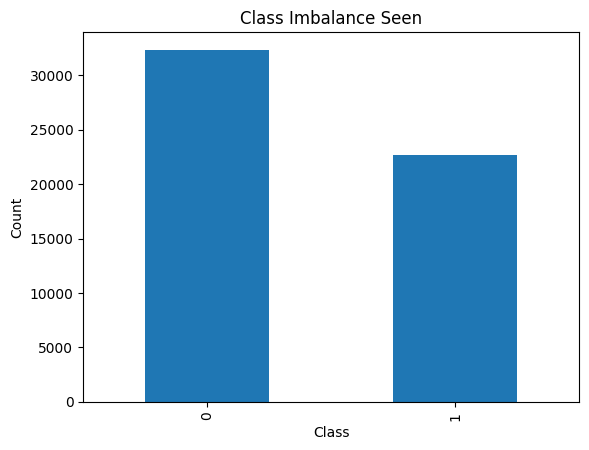

In [ ]:
import matplotlib.pyplot as plt
d=df['ClinSigSimple'].value_counts()
print(d)
d.plot(kind='bar')
plt.title("Class Imbalance Seen")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

No empty values in the dataset

In [ ]:
df.isna().sum()

,0
#AlleleID,0
Type,0
Name,0
GeneID,0
GeneSymbol,0
HGNC_ID,0
ClinicalSignificance,0
ClinSigSimple,0
LastEvaluated,0
RS# (dbSNP),0


In [ ]:
df['Chromosome'].isna().sum()

np.int64(0)

In [ ]:
df['Chromosome']

,Chromosome
7,11
23,6
31,6
35,2
37,2
...,...
699818,16
699868,16
699914,16
699940,16


In [ ]:
df['Start']

,Start
7,126275389
23,26093008
31,26093215
35,19989284
37,19945787
...,...
699818,85921237
699868,89740803
699914,89553792
699940,89749884


In [ ]:
df['Stop']

,Stop
7,126275389
23,26093008
31,26093215
35,19989284
37,19945787
...,...
699818,85921237
699868,89740803
699914,89553792
699940,89749884


In [ ]:
df['ReferenceAlleleVCF']

,ReferenceAlleleVCF
7,C
23,G
31,G
35,T
37,T
...,...
699818,A
699868,C
699914,A
699940,C


In [ ]:
df['AlternateAlleleVCF']

,AlternateAlleleVCF
7,T
23,A
31,T
35,C
37,C
...,...
699818,G
699868,G
699914,G
699940,A


Taking First 20000 rows for ease of working and hardware limitations

In [ ]:
len(df)

55018

Keeping only the columns relevant to my task and dropping other columns.

In [ ]:
columns_to_keep=['Assembly', 'Start', 'Stop', 'Chromosome', 'ClinicalSignificance',"ClinSigSimple"]
df=df[columns_to_keep]
df

,Assembly,Start,Stop,Chromosome,ClinicalSignificance,ClinSigSimple
7,GRCh38,126275389,126275389,11,Pathogenic,1
23,GRCh38,26093008,26093008,6,Benign,0
31,GRCh38,26093215,26093215,6,Pathogenic,1
35,GRCh38,19989284,19989284,2,Pathogenic,1
37,GRCh38,19945787,19945787,2,Pathogenic,1
...,...,...,...,...,...,...
699818,GRCh38,85921237,85921237,16,Benign,0
699868,GRCh38,89740803,89740803,16,Pathogenic,1
699914,GRCh38,89553792,89553792,16,Pathogenic,1
699940,GRCh38,89749884,89749884,16,Pathogenic,1


Unique Chrosome Numbers in the Dataset

In [ ]:
df['Chromosome'].unique()

array(['11', '6', '2', '20', '10', '19', '16', '22', '1', '8', '14', '21',
       '5', '4', '18', '15', '3', '17', '12', '7', '9', '13'],
      dtype=object)

We can see the number of each Chrmosome in the Dataset.

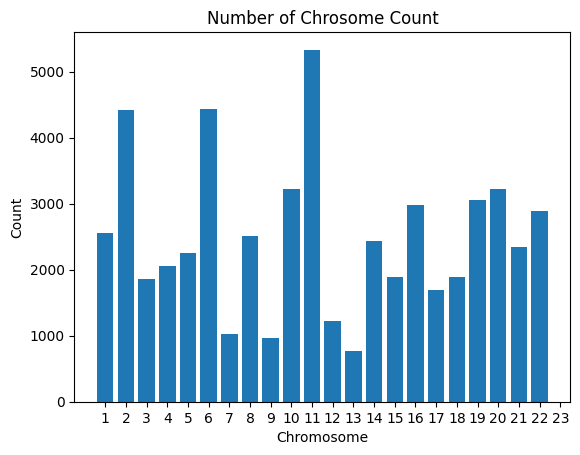

In [57]:
plt.bar(df['Chromosome'].unique(),df['Chromosome'].value_counts())
plt.xticks([i for i in range(1,24)])
plt.xlabel("Chromosome")
plt.title("Number of Chrosome Count")
plt.ylabel("Count")
plt.show()

In [ ]:
df['Chromosome'].value_counts()

,count
Chromosome,
2,5330
1,4435
17,4420
11,3225
3,3221
12,3061
5,2982
16,2893
7,2560


#**Feature Engineering**

Using the **Esembl REST API** to directly download the **GRCh38 human genome build** for each chromosomes individually.

Then unzipping the file individually.

In [ ]:
import time
for i in range(1, 23):
      time.sleep(5)
      !wget ftp://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.{i}.fa.gz
      !gunzip Homo_sapiens.GRCh38.dna.chromosome.{i}.fa.gz


--2025-07-23 15:02:21--  ftp://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.1.fa.gz
           => ‘Homo_sapiens.GRCh38.dna.chromosome.1.fa.gz’
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.169
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.169|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/release-110/fasta/homo_sapiens/dna ... done.
==> SIZE Homo_sapiens.GRCh38.dna.chromosome.1.fa.gz ... 69273468
==> PASV ... done.    ==> RETR Homo_sapiens.GRCh38.dna.chromosome.1.fa.gz ... done.
Length: 69273468 (66M) (unauthoritative)

Homo_sapiens.GRCh38 100%[===================>]  66.06M  25.3MB/s    in 2.6s    

2025-07-23 15:02:25 (25.3 MB/s) - ‘Homo_sapiens.GRCh38.dna.chromosome.1.fa.gz’ saved [69273468]

--2025-07-23 15:02:33--  ftp://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.2.fa.gz
        

There were some issues with downloading the File for Chromosome 10 so I Downloaded it manually later in this code.

In [ ]:
import os
os.remove("/content/Homo_sapiens.GRCh38.dna.chromosome.10.fa.gz")

In [ ]:
!wget ftp://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.{10}.fa.gz
!gunzip Homo_sapiens.GRCh38.dna.chromosome.{10}.fa.gz

--2025-07-23 15:07:10--  ftp://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.10.fa.gz
           => ‘Homo_sapiens.GRCh38.dna.chromosome.10.fa.gz’
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.169
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.169|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/release-110/fasta/homo_sapiens/dna ... done.
==> SIZE Homo_sapiens.GRCh38.dna.chromosome.10.fa.gz ... 40015021
==> PASV ... done.    ==> RETR Homo_sapiens.GRCh38.dna.chromosome.10.fa.gz ... done.
Length: 40015021 (38M) (unauthoritative)

Homo_sapiens.GRCh38 100%[===================>]  38.16M  21.6MB/s    in 1.8s    

2025-07-23 15:07:13 (21.6 MB/s) - ‘Homo_sapiens.GRCh38.dna.chromosome.10.fa.gz’ saved [40015021]



Using **pyfaidx** to read the fasta genomic sequence files.



```
genome=Fasta(f"/content/Homo_sapiens.GRCh38.dna.chromosome.{df['Chromosome'].iloc[i]}.fa")

```
This line creates a **index file** eith the extension **.fai** after reading and parsing the fasta file.


```
  seq=genome[f"{df['Chromosome'].iloc[i]}"][df['Start'].iloc[i]-75:df['Stop'].iloc[i]+75]
```
Then using this line we can read the **.fai** file for any specific index as we want.

Using the above line I got 150 base pair sequence centered on the SNP position:
* I have taken 75 bases upstream from the SNP position using **df['Start']**
* And 74 bases downstream using **df['Stop']**

**This creates a 150 base pair sequence window centered on the variant allele.**






In [ ]:
from pyfaidx import Fasta

ref_allel=[]

for i in range(len(df)):
  genome=Fasta(f"/content/Homo_sapiens.GRCh38.dna.chromosome.{df['Chromosome'].iloc[i]}.fa")

  seq=genome[f"{df['Chromosome'].iloc[i]}"][df['Start'].iloc[i]-75:df['Stop'].iloc[i]+75]
  ref_allel.append(seq.seq)

print(len(ref_allel[0]))
print(len(ref_allel))

150
55018


Added the Reference Sequence in the DataFrame.

In [ ]:
df['Ref_Allel']=ref_allel

/tmp/ipython-input-29-927425774.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ref_Allel']=ref_allel


In [ ]:
df

,Assembly,Start,Stop,Chromosome,ClinicalSignificance,ClinSigSimple,Ref_Allel
7,GRCh38,126275389,126275389,11,Pathogenic,1,TTCTTATCACAGGGATGGAGGACGAAGGTTGGTTTGACCCCTGGTG...
23,GRCh38,26093008,26093008,6,Benign,0,TGGATCAGCCCCTCATTGTGATCTGGGGTATGTGACTGATGAGAGC...
31,GRCh38,26093215,26093215,6,Pathogenic,1,AGTCATTGGAGTCATCAGTGGAATTGCTGTTTTTGTCGTCATCTTG...
35,GRCh38,19989284,19989284,2,Pathogenic,1,CACCGCATGCTATGAACCCTTGTTCCTTGTTCCAGGATACACACTG...
37,GRCh38,19945787,19945787,2,Pathogenic,1,AAAGGGGAATCATCCAGGTTTTTATATTTGGCTCATTATTTATAGA...
...,...,...,...,...,...,...,...
699818,GRCh38,85921237,85921237,16,Benign,0,GGCTCTGTGATGCAGGCCCCCGAGGAGCCGCCGCCAGACCAGGTCT...
699868,GRCh38,89740803,89740803,16,Pathogenic,1,TGGAAGCTGGCTGCCTGGTGCCCCTGCCTGGCCCACAGTGGGAGAG...
699914,GRCh38,89553792,89553792,16,Pathogenic,1,ACCGGGACACCTGGGGCCCAGCACTGCTCTGCGCCTGCAGTGCTGA...
699940,GRCh38,89749884,89749884,16,Pathogenic,1,GCGGAAAATCTCAAAGAGGAAGTGCTCCTGGGAAGGGGTGTGGCCG...


Saved the DataFrame as it was hard to re-run all the steps and download everything from scratch.

In [ ]:
df.to_csv('final_dataset.csv')

In [ ]:
df.head()

,Assembly,Start,Stop,Chromosome,ClinicalSignificance,ClinSigSimple,Ref_Allel
7,GRCh38,126275389,126275389,11,Pathogenic,1,TTCTTATCACAGGGATGGAGGACGAAGGTTGGTTTGACCCCTGGTG...
23,GRCh38,26093008,26093008,6,Benign,0,TGGATCAGCCCCTCATTGTGATCTGGGGTATGTGACTGATGAGAGC...
31,GRCh38,26093215,26093215,6,Pathogenic,1,AGTCATTGGAGTCATCAGTGGAATTGCTGTTTTTGTCGTCATCTTG...
35,GRCh38,19989284,19989284,2,Pathogenic,1,CACCGCATGCTATGAACCCTTGTTCCTTGTTCCAGGATACACACTG...
37,GRCh38,19945787,19945787,2,Pathogenic,1,AAAGGGGAATCATCCAGGTTTTTATATTTGGCTCATTATTTATAGA...


In [ ]:
df

,Assembly,Start,Stop,Chromosome,ClinicalSignificance,ClinSigSimple,Ref_Allel
7,GRCh38,126275389,126275389,11,Pathogenic,1,TTCTTATCACAGGGATGGAGGACGAAGGTTGGTTTGACCCCTGGTG...
23,GRCh38,26093008,26093008,6,Benign,0,TGGATCAGCCCCTCATTGTGATCTGGGGTATGTGACTGATGAGAGC...
31,GRCh38,26093215,26093215,6,Pathogenic,1,AGTCATTGGAGTCATCAGTGGAATTGCTGTTTTTGTCGTCATCTTG...
35,GRCh38,19989284,19989284,2,Pathogenic,1,CACCGCATGCTATGAACCCTTGTTCCTTGTTCCAGGATACACACTG...
37,GRCh38,19945787,19945787,2,Pathogenic,1,AAAGGGGAATCATCCAGGTTTTTATATTTGGCTCATTATTTATAGA...
...,...,...,...,...,...,...,...
699818,GRCh38,85921237,85921237,16,Benign,0,GGCTCTGTGATGCAGGCCCCCGAGGAGCCGCCGCCAGACCAGGTCT...
699868,GRCh38,89740803,89740803,16,Pathogenic,1,TGGAAGCTGGCTGCCTGGTGCCCCTGCCTGGCCCACAGTGGGAGAG...
699914,GRCh38,89553792,89553792,16,Pathogenic,1,ACCGGGACACCTGGGGCCCAGCACTGCTCTGCGCCTGCAGTGCTGA...
699940,GRCh38,89749884,89749884,16,Pathogenic,1,GCGGAAAATCTCAAAGAGGAAGTGCTCCTGGGAAGGGGTGTGGCCG...


This basically has the string "na" so it does not show up when I check whether any column has any mission value or not.

In [ ]:
df2['AlternateAllele']

,AlternateAllele
5,na
7,na
9,na
11,na
13,na
...,...
699988,na
699990,na
699992,na
699994,na


The **"AlternateAlleleVCF"** column actually had the alternate alleles.

In [ ]:
df4=df4["AlternateAlleleVCF"]

In [ ]:
df4

,AlternateAlleleVCF
7,T
23,A
31,T
35,C
37,C
...,...
699818,G
699868,G
699914,G
699940,A


I have added the Alternate Alleles to my DataFrame under the column **Alt**.

In [ ]:
df['Alt']=df4

/tmp/ipython-input-37-686683678.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Alt']=df4


In [ ]:
df

,Assembly,Start,Stop,Chromosome,ClinicalSignificance,ClinSigSimple,Ref_Allel,Alt
7,GRCh38,126275389,126275389,11,Pathogenic,1,TTCTTATCACAGGGATGGAGGACGAAGGTTGGTTTGACCCCTGGTG...,T
23,GRCh38,26093008,26093008,6,Benign,0,TGGATCAGCCCCTCATTGTGATCTGGGGTATGTGACTGATGAGAGC...,A
31,GRCh38,26093215,26093215,6,Pathogenic,1,AGTCATTGGAGTCATCAGTGGAATTGCTGTTTTTGTCGTCATCTTG...,T
35,GRCh38,19989284,19989284,2,Pathogenic,1,CACCGCATGCTATGAACCCTTGTTCCTTGTTCCAGGATACACACTG...,C
37,GRCh38,19945787,19945787,2,Pathogenic,1,AAAGGGGAATCATCCAGGTTTTTATATTTGGCTCATTATTTATAGA...,C
...,...,...,...,...,...,...,...,...
699818,GRCh38,85921237,85921237,16,Benign,0,GGCTCTGTGATGCAGGCCCCCGAGGAGCCGCCGCCAGACCAGGTCT...,G
699868,GRCh38,89740803,89740803,16,Pathogenic,1,TGGAAGCTGGCTGCCTGGTGCCCCTGCCTGGCCCACAGTGGGAGAG...,G
699914,GRCh38,89553792,89553792,16,Pathogenic,1,ACCGGGACACCTGGGGCCCAGCACTGCTCTGCGCCTGCAGTGCTGA...,G
699940,GRCh38,89749884,89749884,16,Pathogenic,1,GCGGAAAATCTCAAAGAGGAAGTGCTCCTGGGAAGGGGTGTGGCCG...,A


Here I performed one of the most important feature engineering steps in the entire pipeline.

Using the code below,I started with the reference sequence (stored in the column **Ref_Allel**), and then created the alternate sequence by replacing the 75th base the center of the 150 bp window  with the alternate allele from the column **Alt**.

This simulates the actual variant occurring at that position.


```
alt_seq = ref_seq[:74] + df['Alt'].iloc[i] + ref_seq[75:]
```

After creating the alternate sequence, I added it to the DataFrame under a new column called **Alt_Allel**.

This dual representation both reference and alternate sequences allows the model to directly compare the effect of the SNP and learn sequence level differences between pathogenic and benign variants.

In [ ]:
alt_seqs=[]

for i in range(len(df)):
    ref_seq=df['Ref_Allel'].iloc[i]
    alt=df['Alt'].iloc[i]

    mid=len(ref_seq)//2
    alt_seq=ref_seq[:mid]+alt+ref_seq[mid+1:]
    alt_seqs.append(alt_seq)

df['Alt_Allel']=alt_seqs

/tmp/ipython-input-39-997341664.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Alt_Allel']=alt_seqs


In [ ]:
alt=df['Alt'].iloc[5]
print(alt)

A


In [ ]:
df

,Assembly,Start,Stop,Chromosome,ClinicalSignificance,ClinSigSimple,Ref_Allel,Alt,Alt_Allel
7,GRCh38,126275389,126275389,11,Pathogenic,1,TTCTTATCACAGGGATGGAGGACGAAGGTTGGTTTGACCCCTGGTG...,T,TTCTTATCACAGGGATGGAGGACGAAGGTTGGTTTGACCCCTGGTG...
23,GRCh38,26093008,26093008,6,Benign,0,TGGATCAGCCCCTCATTGTGATCTGGGGTATGTGACTGATGAGAGC...,A,TGGATCAGCCCCTCATTGTGATCTGGGGTATGTGACTGATGAGAGC...
31,GRCh38,26093215,26093215,6,Pathogenic,1,AGTCATTGGAGTCATCAGTGGAATTGCTGTTTTTGTCGTCATCTTG...,T,AGTCATTGGAGTCATCAGTGGAATTGCTGTTTTTGTCGTCATCTTG...
35,GRCh38,19989284,19989284,2,Pathogenic,1,CACCGCATGCTATGAACCCTTGTTCCTTGTTCCAGGATACACACTG...,C,CACCGCATGCTATGAACCCTTGTTCCTTGTTCCAGGATACACACTG...
37,GRCh38,19945787,19945787,2,Pathogenic,1,AAAGGGGAATCATCCAGGTTTTTATATTTGGCTCATTATTTATAGA...,C,AAAGGGGAATCATCCAGGTTTTTATATTTGGCTCATTATTTATAGA...
...,...,...,...,...,...,...,...,...,...
699818,GRCh38,85921237,85921237,16,Benign,0,GGCTCTGTGATGCAGGCCCCCGAGGAGCCGCCGCCAGACCAGGTCT...,G,GGCTCTGTGATGCAGGCCCCCGAGGAGCCGCCGCCAGACCAGGTCT...
699868,GRCh38,89740803,89740803,16,Pathogenic,1,TGGAAGCTGGCTGCCTGGTGCCCCTGCCTGGCCCACAGTGGGAGAG...,G,TGGAAGCTGGCTGCCTGGTGCCCCTGCCTGGCCCACAGTGGGAGAG...
699914,GRCh38,89553792,89553792,16,Pathogenic,1,ACCGGGACACCTGGGGCCCAGCACTGCTCTGCGCCTGCAGTGCTGA...,G,ACCGGGACACCTGGGGCCCAGCACTGCTCTGCGCCTGCAGTGCTGA...
699940,GRCh38,89749884,89749884,16,Pathogenic,1,GCGGAAAATCTCAAAGAGGAAGTGCTCCTGGGAAGGGGTGTGGCCG...,A,GCGGAAAATCTCAAAGAGGAAGTGCTCCTGGGAAGGGGTGTGGCCG...


In [ ]:
print(len(df['Ref_Allel'].iloc[2]))


150


In [ ]:
print(len(df['Alt_Allel'].iloc[2]))

150


Here also I downloaded the Final Dataset in csv format to use it later as it is really hard to run and download everything from scratch.

In [ ]:
df.to_csv("Fully_Final.csv")

In [ ]:
df

,Assembly,Start,Stop,Chromosome,ClinicalSignificance,ClinSigSimple,Ref_Allel,Alt,Alt_Allel
7,GRCh38,126275389,126275389,11,Pathogenic,1,TTCTTATCACAGGGATGGAGGACGAAGGTTGGTTTGACCCCTGGTG...,T,TTCTTATCACAGGGATGGAGGACGAAGGTTGGTTTGACCCCTGGTG...
23,GRCh38,26093008,26093008,6,Benign,0,TGGATCAGCCCCTCATTGTGATCTGGGGTATGTGACTGATGAGAGC...,A,TGGATCAGCCCCTCATTGTGATCTGGGGTATGTGACTGATGAGAGC...
31,GRCh38,26093215,26093215,6,Pathogenic,1,AGTCATTGGAGTCATCAGTGGAATTGCTGTTTTTGTCGTCATCTTG...,T,AGTCATTGGAGTCATCAGTGGAATTGCTGTTTTTGTCGTCATCTTG...
35,GRCh38,19989284,19989284,2,Pathogenic,1,CACCGCATGCTATGAACCCTTGTTCCTTGTTCCAGGATACACACTG...,C,CACCGCATGCTATGAACCCTTGTTCCTTGTTCCAGGATACACACTG...
37,GRCh38,19945787,19945787,2,Pathogenic,1,AAAGGGGAATCATCCAGGTTTTTATATTTGGCTCATTATTTATAGA...,C,AAAGGGGAATCATCCAGGTTTTTATATTTGGCTCATTATTTATAGA...
...,...,...,...,...,...,...,...,...,...
699818,GRCh38,85921237,85921237,16,Benign,0,GGCTCTGTGATGCAGGCCCCCGAGGAGCCGCCGCCAGACCAGGTCT...,G,GGCTCTGTGATGCAGGCCCCCGAGGAGCCGCCGCCAGACCAGGTCT...
699868,GRCh38,89740803,89740803,16,Pathogenic,1,TGGAAGCTGGCTGCCTGGTGCCCCTGCCTGGCCCACAGTGGGAGAG...,G,TGGAAGCTGGCTGCCTGGTGCCCCTGCCTGGCCCACAGTGGGAGAG...
699914,GRCh38,89553792,89553792,16,Pathogenic,1,ACCGGGACACCTGGGGCCCAGCACTGCTCTGCGCCTGCAGTGCTGA...,G,ACCGGGACACCTGGGGCCCAGCACTGCTCTGCGCCTGCAGTGCTGA...
699940,GRCh38,89749884,89749884,16,Pathogenic,1,GCGGAAAATCTCAAAGAGGAAGTGCTCCTGGGAAGGGGTGTGGCCG...,A,GCGGAAAATCTCAAAGAGGAAGTGCTCCTGGGAAGGGGTGTGGCCG...


After generating the reference and alternate sequences, I performed a check to ensure that all samples in the columns **Ref_Allel** and **Alt_Alle** have a different base at the 75th position which corresponds to the SNP location in the 150 bp sequence window.


But I got that only 43675 out of 55018 samples in my DataFrame had a SNP.


Later I realised using the code:

```
c=0
for i in range(100):
  if df['Ref_Allel'].iloc[i][75]==df['Alt'].iloc[i]:
    c=c+1
print(c)

```
This revealed that in 27 out of 100 randomly samples, the alternate allele was the same as the reference base meaning no actual SNP was present in those sequences.

So maybe there is some issue with the dataset from CLinVar that I am using as I have rechekd my implementation and I think it was correct.

Then also I left those in my data as I thought that basically they had no chnage so they would be **Bening** so anyways my model can learn from them.


In [ ]:
# Checking that only position 75 differs,and all others are same
def different(ref, alt):
    if len(ref)!=150 or len(alt)!=150:
        return False
    if ref[75]==alt[75]:
        return False
    for i in range(150):
        if i!=75 and ref[i]!=alt[i]:
            return False
    return True

correct_rows=df.apply(lambda row:different(row['Ref_Allel'],row['Alt_Allel']),axis=1)
print(f"{correct_rows.sum()} out of {len(df)} sequences have SNP only at position 75")


43675 out of 55018 sequences have SNP only at position 75


Some rows the Alt Allele nuclotide is same as that of the nuclotide in the Ref_Sequence

In [59]:
c=0
for i in range(100):
  if df['Ref_Allel'].iloc[i][75]==df['Alt'].iloc[i]:
    c=c+1
print(c)

27


In [ ]:
y=df['ClinSigSimple']

In [ ]:
y

,ClinSigSimple
7,1
23,0
31,1
35,1
37,1
...,...
699818,0
699868,1
699914,1
699940,1


Reading the Fully_Final dataset that I will use for training the custom model.

In [1]:
import pandas as pd
df=pd.read_csv("Fully_Final (1).csv")
df

,Unnamed: 0,Assembly,Start,Stop,Chromosome,ClinicalSignificance,ClinSigSimple,Ref_Allel,Alt,Alt_Allel
0,7,GRCh38,126275389,126275389,11,Pathogenic,1,TTCTTATCACAGGGATGGAGGACGAAGGTTGGTTTGACCCCTGGTG...,T,TTCTTATCACAGGGATGGAGGACGAAGGTTGGTTTGACCCCTGGTG...
1,23,GRCh38,26093008,26093008,6,Benign,0,TGGATCAGCCCCTCATTGTGATCTGGGGTATGTGACTGATGAGAGC...,A,TGGATCAGCCCCTCATTGTGATCTGGGGTATGTGACTGATGAGAGC...
2,31,GRCh38,26093215,26093215,6,Pathogenic,1,AGTCATTGGAGTCATCAGTGGAATTGCTGTTTTTGTCGTCATCTTG...,T,AGTCATTGGAGTCATCAGTGGAATTGCTGTTTTTGTCGTCATCTTG...
3,35,GRCh38,19989284,19989284,2,Pathogenic,1,CACCGCATGCTATGAACCCTTGTTCCTTGTTCCAGGATACACACTG...,C,CACCGCATGCTATGAACCCTTGTTCCTTGTTCCAGGATACACACTG...
4,37,GRCh38,19945787,19945787,2,Pathogenic,1,AAAGGGGAATCATCCAGGTTTTTATATTTGGCTCATTATTTATAGA...,C,AAAGGGGAATCATCCAGGTTTTTATATTTGGCTCATTATTTATAGA...
...,...,...,...,...,...,...,...,...,...,...
55013,699818,GRCh38,85921237,85921237,16,Benign,0,GGCTCTGTGATGCAGGCCCCCGAGGAGCCGCCGCCAGACCAGGTCT...,G,GGCTCTGTGATGCAGGCCCCCGAGGAGCCGCCGCCAGACCAGGTCT...
55014,699868,GRCh38,89740803,89740803,16,Pathogenic,1,TGGAAGCTGGCTGCCTGGTGCCCCTGCCTGGCCCACAGTGGGAGAG...,G,TGGAAGCTGGCTGCCTGGTGCCCCTGCCTGGCCCACAGTGGGAGAG...
55015,699914,GRCh38,89553792,89553792,16,Pathogenic,1,ACCGGGACACCTGGGGCCCAGCACTGCTCTGCGCCTGCAGTGCTGA...,G,ACCGGGACACCTGGGGCCCAGCACTGCTCTGCGCCTGCAGTGCTGA...
55016,699940,GRCh38,89749884,89749884,16,Pathogenic,1,GCGGAAAATCTCAAAGAGGAAGTGCTCCTGGGAAGGGGTGTGGCCG...,A,GCGGAAAATCTCAAAGAGGAAGTGCTCCTGGGAAGGGGTGTGGCCG...


To convert the DNA sequences into a numerical format suitable for input into the neural network, I applied **Label Encoding** to both the *Reference Sequence* and the *Alternate Sequence*.

Each nucleotide base was mapped to a unique integer:
* Adenine(A)=> 0
* Cytosine(C)=> 1
* Guanine(G)=> 2
* Thiamine(T)=> 3
* Ambigious Base(N)=> 4

I specifically chose **Label Encoding** (instead of one-hot encoding) because it preserves the **positional information** of each base across the sequence.

By assigning a fixed integer to each base, the model can learn base specific patterns at each position for example, that a 1 at position 75 means Adenine occurs at the SNP location, and the model may associate this with a certain prediction behavior.

While label encoding introduces an implicit ordinal relationship between bases (which biologically doesn’t exist),it still works well here because the model learns embeddings on top of these labels allowing it to represent each base as a learnable vector instead of relying on numeric values just.

In [2]:
import tensorflow as tf
import numpy as np
from keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer

base_to_idx={'A': 0,'C': 1,'G': 2,'T': 3,'N': 4}

def encode_seq(seq):
    return [base_to_idx.get(base,4) for base in seq]

df['Ref_Encoded']=df['Ref_Allel'].apply(encode_seq)
df['Alt_Encoded']=df['Alt_Allel'].apply(encode_seq)

In [3]:
df

,Unnamed: 0,Assembly,Start,Stop,Chromosome,ClinicalSignificance,ClinSigSimple,Ref_Allel,Alt,Alt_Allel,Ref_Encoded,Alt_Encoded
0,7,GRCh38,126275389,126275389,11,Pathogenic,1,TTCTTATCACAGGGATGGAGGACGAAGGTTGGTTTGACCCCTGGTG...,T,TTCTTATCACAGGGATGGAGGACGAAGGTTGGTTTGACCCCTGGTG...,"[3, 3, 1, 3, 3, 0, 3, 1, 0, 1, 0, 2, 2, 2, 0, ...","[3, 3, 1, 3, 3, 0, 3, 1, 0, 1, 0, 2, 2, 2, 0, ..."
1,23,GRCh38,26093008,26093008,6,Benign,0,TGGATCAGCCCCTCATTGTGATCTGGGGTATGTGACTGATGAGAGC...,A,TGGATCAGCCCCTCATTGTGATCTGGGGTATGTGACTGATGAGAGC...,"[3, 2, 2, 0, 3, 1, 0, 2, 1, 1, 1, 1, 3, 1, 0, ...","[3, 2, 2, 0, 3, 1, 0, 2, 1, 1, 1, 1, 3, 1, 0, ..."
2,31,GRCh38,26093215,26093215,6,Pathogenic,1,AGTCATTGGAGTCATCAGTGGAATTGCTGTTTTTGTCGTCATCTTG...,T,AGTCATTGGAGTCATCAGTGGAATTGCTGTTTTTGTCGTCATCTTG...,"[0, 2, 3, 1, 0, 3, 3, 2, 2, 0, 2, 3, 1, 0, 3, ...","[0, 2, 3, 1, 0, 3, 3, 2, 2, 0, 2, 3, 1, 0, 3, ..."
3,35,GRCh38,19989284,19989284,2,Pathogenic,1,CACCGCATGCTATGAACCCTTGTTCCTTGTTCCAGGATACACACTG...,C,CACCGCATGCTATGAACCCTTGTTCCTTGTTCCAGGATACACACTG...,"[1, 0, 1, 1, 2, 1, 0, 3, 2, 1, 3, 0, 3, 2, 0, ...","[1, 0, 1, 1, 2, 1, 0, 3, 2, 1, 3, 0, 3, 2, 0, ..."
4,37,GRCh38,19945787,19945787,2,Pathogenic,1,AAAGGGGAATCATCCAGGTTTTTATATTTGGCTCATTATTTATAGA...,C,AAAGGGGAATCATCCAGGTTTTTATATTTGGCTCATTATTTATAGA...,"[0, 0, 0, 2, 2, 2, 2, 0, 0, 3, 1, 0, 3, 1, 1, ...","[0, 0, 0, 2, 2, 2, 2, 0, 0, 3, 1, 0, 3, 1, 1, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
55013,699818,GRCh38,85921237,85921237,16,Benign,0,GGCTCTGTGATGCAGGCCCCCGAGGAGCCGCCGCCAGACCAGGTCT...,G,GGCTCTGTGATGCAGGCCCCCGAGGAGCCGCCGCCAGACCAGGTCT...,"[2, 2, 1, 3, 1, 3, 2, 3, 2, 0, 3, 2, 1, 0, 2, ...","[2, 2, 1, 3, 1, 3, 2, 3, 2, 0, 3, 2, 1, 0, 2, ..."
55014,699868,GRCh38,89740803,89740803,16,Pathogenic,1,TGGAAGCTGGCTGCCTGGTGCCCCTGCCTGGCCCACAGTGGGAGAG...,G,TGGAAGCTGGCTGCCTGGTGCCCCTGCCTGGCCCACAGTGGGAGAG...,"[3, 2, 2, 0, 0, 2, 1, 3, 2, 2, 1, 3, 2, 1, 1, ...","[3, 2, 2, 0, 0, 2, 1, 3, 2, 2, 1, 3, 2, 1, 1, ..."
55015,699914,GRCh38,89553792,89553792,16,Pathogenic,1,ACCGGGACACCTGGGGCCCAGCACTGCTCTGCGCCTGCAGTGCTGA...,G,ACCGGGACACCTGGGGCCCAGCACTGCTCTGCGCCTGCAGTGCTGA...,"[0, 1, 1, 2, 2, 2, 0, 1, 0, 1, 1, 3, 2, 2, 2, ...","[0, 1, 1, 2, 2, 2, 0, 1, 0, 1, 1, 3, 2, 2, 2, ..."
55016,699940,GRCh38,89749884,89749884,16,Pathogenic,1,GCGGAAAATCTCAAAGAGGAAGTGCTCCTGGGAAGGGGTGTGGCCG...,A,GCGGAAAATCTCAAAGAGGAAGTGCTCCTGGGAAGGGGTGTGGCCG...,"[2, 1, 2, 2, 0, 0, 0, 0, 3, 1, 3, 1, 0, 0, 0, ...","[2, 1, 2, 2, 0, 0, 0, 0, 3, 1, 3, 1, 0, 0, 0, ..."


Label Encoded Reference Sequence

In [4]:
df['Ref_Encoded']

,Ref_Encoded
0,"[3, 3, 1, 3, 3, 0, 3, 1, 0, 1, 0, 2, 2, 2, 0, ..."
1,"[3, 2, 2, 0, 3, 1, 0, 2, 1, 1, 1, 1, 3, 1, 0, ..."
2,"[0, 2, 3, 1, 0, 3, 3, 2, 2, 0, 2, 3, 1, 0, 3, ..."
3,"[1, 0, 1, 1, 2, 1, 0, 3, 2, 1, 3, 0, 3, 2, 0, ..."
4,"[0, 0, 0, 2, 2, 2, 2, 0, 0, 3, 1, 0, 3, 1, 1, ..."
...,...
55013,"[2, 2, 1, 3, 1, 3, 2, 3, 2, 0, 3, 2, 1, 0, 2, ..."
55014,"[3, 2, 2, 0, 0, 2, 1, 3, 2, 2, 1, 3, 2, 1, 1, ..."
55015,"[0, 1, 1, 2, 2, 2, 0, 1, 0, 1, 1, 3, 2, 2, 2, ..."
55016,"[2, 1, 2, 2, 0, 0, 0, 0, 3, 1, 3, 1, 0, 0, 0, ..."


Label Encoded Alternate Sequence

In [5]:
df['Alt_Encoded']

,Alt_Encoded
0,"[3, 3, 1, 3, 3, 0, 3, 1, 0, 1, 0, 2, 2, 2, 0, ..."
1,"[3, 2, 2, 0, 3, 1, 0, 2, 1, 1, 1, 1, 3, 1, 0, ..."
2,"[0, 2, 3, 1, 0, 3, 3, 2, 2, 0, 2, 3, 1, 0, 3, ..."
3,"[1, 0, 1, 1, 2, 1, 0, 3, 2, 1, 3, 0, 3, 2, 0, ..."
4,"[0, 0, 0, 2, 2, 2, 2, 0, 0, 3, 1, 0, 3, 1, 1, ..."
...,...
55013,"[2, 2, 1, 3, 1, 3, 2, 3, 2, 0, 3, 2, 1, 0, 2, ..."
55014,"[3, 2, 2, 0, 0, 2, 1, 3, 2, 2, 1, 3, 2, 1, 1, ..."
55015,"[0, 1, 1, 2, 2, 2, 0, 1, 0, 1, 1, 3, 2, 2, 2, ..."
55016,"[2, 1, 2, 2, 0, 0, 0, 0, 3, 1, 3, 1, 0, 0, 0, ..."


Assigned the columns into different variables to be given input to my model.

In [6]:
X_ref=df['Ref_Encoded']
X_alt=df['Alt_Encoded']

y is the target variable and it contains;

class 1 (Pathogenic) and class 0 (Bening)

In [7]:
y=df['ClinSigSimple']

In [8]:
X_ref.shape

(55018,)

In [9]:
X_alt.shape

(55018,)

Here I encoutered an error while converting **X_alt** into numpy array.

And I found out that row with the index 52400 had 151 bases instaed of 150 bases. But I could not detect why it was happening, so I thought of dropping the entire row 52400 from my data.

In [10]:
for i, item in enumerate(X_alt):
    if len(item)!=150:
      print(i)
len(X_alt.iloc[52400])

52400


151

In [11]:
X_alt=X_alt.drop(index=52400).reset_index(drop=True)

In [12]:
X_ref=X_ref.drop(index=52400).reset_index(drop=True)


In [13]:
import numpy as np

X_ref=np.array(X_ref.tolist())
X_alt=np.array(X_alt.tolist())

print(X_ref.shape,X_alt.shape)

(55017, 150) (55017, 150)


In [14]:
X_ref.shape

(55017, 150)

In [15]:
X_alt.shape

(55017, 150)

In [16]:
y=y.drop(index=52400).reset_index(drop=True)

Splitting the Data into Train and Test set.

In [17]:
from sklearn.model_selection import train_test_split
X_ref_train,X_ref_test,X_alt_train,X_alt_test,y_train,y_test=train_test_split(X_ref,X_alt,y,test_size=0.2)

In [18]:
X_ref_train.shape

(44013, 150)

In [19]:
X_alt_train.shape

(44013, 150)

In [20]:
print(X_ref_test.shape)
print(X_ref_test.shape)

(11004, 150)
(11004, 150)


In [21]:
print(y_train.shape)
print(y_test.shape)

(44013,)
(11004,)


So after splitting my traning data had 44013 samples and my testing data had 11004 samples.

#SMOTE
**Run it if you want to use SMOTE**

**Other wise don't run it , instead run the UnderSampling Block**

Then to counter the class imbalance I used **SMOTE(Synthetic Minority Oversampling Technique)**.

Basically **SMOTE**;
* First indentifies K-nearest neighbours of a random minority sample
* Among the neighbours a random neighour is choosen and a point is calculated in between the minority class sample and the neighbour and the calculated point is said to be of the same class as the minority class.

So **SMOTE** creates aritifical samples of the minority class on a straight line between the random sample and the neighbour.



```
new_sample = sample + λ × (neighbor - sample)
```

This may create floating values as we use a randomly choosen parameter Lambda in the SMOTE technique and it is between 0 and 1. So we may get floating point numbers.

But our Embedding Layer in the model does not take into account floating point numbers it only takes into account integer values of 0,1,2,3,4 has I have given;

```
input_dim=5
```
But **Keras** comes to our rescue, as it automatically converts floating point numbers to integers before passing to Embedding Layer so thats why it works wihtout explicit typcasting.


But another issue is that **SMOTE** creates synthetic data and it may not represent real Biological Sequences so the model may learn unnecessary features.


In [22]:
from imblearn.over_sampling import SMOTE

# Flatten both sequences
X_flat=np.concatenate([X_ref_train,X_alt_train],axis=1)
print(X_flat.shape)
print(X_flat)
print(y_train.shape)
#SMOTE
X_resampled_train,y_resampled_train=SMOTE().fit_resample(X_flat, y_train)

# Split back to ref and alt
X_ref_train=X_resampled_train[:, :X_ref.shape[1]]
X_alt_train=X_resampled_train[:, X_ref.shape[1]:]
y_train=np.array(y_resampled_train)

(44013, 300)
[[2 0 0 ... 2 3 1]
 [2 0 2 ... 2 1 2]
 [0 0 1 ... 3 2 0]
 ...
 [0 3 1 ... 2 2 3]
 [3 1 3 ... 0 1 0]
 [3 2 3 ... 1 0 3]]
(44013,)


#UnderSampling
**Run this to use Under Sampling other wise don't run it.**

**Go to the next step if you dont run it**

In UnderSampling we just Randomly choose samples from the Majority class to make the minority class number same as the majority class number.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
# Flatten both sequences
X_flat=np.concatenate([X_ref_train,X_alt_train],axis=1)
print(X_flat.shape)
print(X_flat)
print(y_train.shape)

#Undersamnpling
X_resampled_train,y_resampled_train=RandomUnderSampler().fit_resample(X_flat, y_train)
X_ref_train=X_resampled_train[:, :X_ref.shape[1]]
X_alt_train=X_resampled_train[:, X_ref.shape[1]:]
y_train=np.array(y_resampled_train)


(44013, 300)
[[3 3 1 ... 2 3 3]
 [1 2 3 ... 0 1 3]
 [1 3 1 ... 3 1 1]
 ...
 [1 1 1 ... 3 0 2]
 [3 3 3 ... 1 3 1]
 [2 2 2 ... 2 0 0]]
(44013,)


In [ ]:
X_ref_train.shape

(51804, 150)

In [ ]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
pd.Series(y_train).value_counts()

,count
0,25902
1,25902


In [ ]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
X_ref_train.shape

(51804, 150)

In [ ]:
X_alt_train.shape

(51804, 150)

In [ ]:
pd.Series(y_train).value_counts()

,count
0,25902
1,25902


# **Model Building**
**Compulsory to run to build the model**

I designed a custom dual-input CNN-LSTM model with embedding layers to classify SNPs using the reference and alternate DNA sequences.

My thought process was as follows:
* The Embedding layer converts each base (A, C, G, T, N) into a dense vector representation. This allows the model to learn meaningful representations of bases beyond simple integer labels. Both the reference and alternate sequences are passed through separate embedding layers
* The output of the embedding layer is a 150 × embedding_dim(32) matrix, representing the 150 base pairs around the SNP for each sequence.
* These embedded sequences are then passed through a 1D Convolution layer, which is responsible for detecting local patterns or motifs in the DNA sequence similar to how CNNs detect features in images.
* After that, a LSTM layer processes the output of the convolutional layer to learn long-term dependencies and sequential relationships between bases in the DNA sequence.
* Finally, the encoded representations of the reference and alternate sequences are merged and passed through dense layers for the final prediction.

This architecture allows the model to **independently learn features from both versions of the sequence**, **compare their representations effectively** and **predict the effect of a SNP by understanding how introducing the alternate allele changes the sequence-level context.**

In [64]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Concatenate
from tensorflow.keras import regularizers
from keras.losses import BinaryFocalCrossentropy

input_len=150
vocab_size=5
embed_dim=32

# Reference input branch
input_ref=Input(shape=(input_len,))
x_ref=Embedding(input_dim=vocab_size,output_dim=embed_dim)(input_ref)
x_ref=Conv1D(filters=64,kernel_size=5,activation='relu',
               kernel_regularizer=regularizers.l2(0.000))(x_ref)
x_ref=MaxPooling1D(pool_size=2)(x_ref)
x_ref=LSTM(32,kernel_regularizer=regularizers.l2(0.000))(x_ref)
x_ref=Dropout(0.3)(x_ref)

# Alternate input branch
input_alt=Input(shape=(input_len,))
x_alt=Embedding(input_dim=vocab_size,output_dim=embed_dim)(input_alt)
x_alt=Conv1D(filters=64, kernel_size=5, activation='relu',
               kernel_regularizer=regularizers.l2(0.000))(x_alt)
x_alt=MaxPooling1D(pool_size=2)(x_alt)
x_alt=LSTM(32,kernel_regularizer=regularizers.l2(0.000))(x_alt)
x_alt=Dropout(0.3)(x_alt)

# Merging branches
merged=Concatenate()([x_ref, x_alt])
merged=Dense(128,activation='relu',
               kernel_regularizer=regularizers.l2(0.000))(merged)
merged=Dropout(0.3)(merged)

output=Dense(1,activation='sigmoid')(merged)

model=Model(inputs=[input_ref, input_alt],outputs=output)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_31      │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 150, 32)   │        160 │ input_layer_30[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 150, 32)   │        160 │ input_layer_31[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 146, 64)   │     10,304 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 146, 64)   │     10,304 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 73, 64)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 73, 64)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 32)        │     12,416 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,320 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,209 (211.75 KB)

 Trainable params: 54,209 (211.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
y_train = np.array(y_train.tolist())
print(y_train.shape)
y_test = np.array(y_test.tolist())
print(y_test.shape)

(51636,)
(11004,)


In [ ]:
print(X_ref_test.shape)
print(X_alt_test.shape)

(11004, 150)
(11004, 150)


In [ ]:
X_ref_test.shape

(11004, 150)

In [ ]:
X_alt_test

array([[3, 0, 0, ..., 0, 0, 0],
       [0, 2, 2, ..., 1, 1, 0],
       [1, 3, 3, ..., 0, 1, 0],
       ...,
       [2, 2, 0, ..., 1, 3, 2],
       [2, 1, 0, ..., 2, 2, 1],
       [2, 0, 3, ..., 2, 3, 2]])

In [ ]:
print(X_alt_train.shape)
print(X_ref_train.shape)

(51636, 150)
(51636, 150)


In [ ]:
X_alt_train

array([[1, 3, 2, ..., 3, 1, 3],
       [3, 2, 3, ..., 0, 1, 3],
       [1, 0, 2, ..., 0, 2, 2],
       ...,
       [1, 1, 2, ..., 2, 0, 1],
       [2, 1, 2, ..., 1, 2, 0],
       [1, 1, 2, ..., 2, 0, 2]])

Here we can see that after SMOTE the number of class 1 samples and the number of class 0 samples are same.

In [ ]:
pd.Series(y_train).value_counts()

,count
1,25818
0,25818


In [ ]:
y_train.shape

(51636,)

In [ ]:
y_train

array([1, 1, 1, ..., 1, 1, 1])

I also added the class weight though basically it was not needed then also I just added it.

In [61]:
from sklearn.utils.class_weight import compute_class_weight

class_weights=compute_class_weight('balanced',classes=np.unique(y_train),y=y_train)
class_weights_dict=dict(enumerate(class_weights))
print(class_weights_dict)

{0: np.float64(1.0), 1: np.float64(1.0)}


Traning the model and also using Early stopping.

In [65]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

history=model.fit(
    [X_ref_train, X_alt_train], y_train,
    validation_data=([X_ref_test, X_alt_test], y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

Epoch 1/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 122s 140ms/step - accuracy: 0.6103 - loss: 0.6345 - val_accuracy: 0.5780 - val_loss: 0.6908
Epoch 2/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 125s 118ms/step - accuracy: 0.6359 - loss: 0.6028 - val_accuracy: 0.5669 - val_loss: 0.7149
Epoch 3/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 134s 109ms/step - accuracy: 0.6362 - loss: 0.6004 - val_accuracy: 0.5774 - val_loss: 0.6942
Epoch 4/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 141s 108ms/step - accuracy: 0.6404 - loss: 0.5972 - val_accuracy: 0.5830 - val_loss: 0.6941
Epoch 5/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 143s 109ms/step - accuracy: 0.6408 - loss: 0.5954 - val_accuracy: 0.5827 - val_loss: 0.6926
Epoch 6/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 139s 106ms/step - accuracy: 0.6414 - loss: 0.5936 - val_accuracy: 0.5828 - val_loss: 0.6889
Epoch 7/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 86s 106ms/step - accuracy: 0.6421 - loss: 0.5873 - val_accuracy: 0.5820 - val_loss: 0.6902
Epoch 8/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 86s 107ms/step - accuracy: 0.6493 - l

In [ ]:
model.weights

[<Variable path=embedding_2/embeddings, shape=(5, 32), dtype=float32, value=[[ 2.33898778e-02  7.02181086e-02  7.58046135e-02 -4.38233577e-02
    1.93844646e-01  2.11059034e-01  1.23492204e-01 -1.25126705e-01
   -2.55103618e-01 -5.21781594e-02  2.26666033e-02  1.75592512e-01
    1.41873673e-01 -3.09607714e-01  7.27819428e-02  7.44437799e-02
    1.00400090e-01 -1.62389547e-01 -3.57927233e-02 -3.87706995e-01
    2.05599457e-01 -1.49202496e-01  3.03855888e-03  1.59935534e-01
   -3.99335772e-02  1.14519432e-01  1.26353338e-01 -6.88961288e-03
   -6.31031245e-02  2.62599021e-01  3.33367800e-03 -8.58923718e-02]
  [-1.95653364e-01  7.33357817e-02  8.63787066e-03 -1.88718811e-01
   -8.59909356e-02 -1.19377896e-01 -1.85398713e-01 -1.49933591e-01
    6.38160557e-02 -3.43635418e-02 -1.17358051e-01 -3.19955312e-02
    3.10484543e-02  1.38532996e-01  1.45132184e-01 -2.65035108e-02
    5.26589863e-02 -7.15080649e-02  3.51283737e-02  2.69757509e-01
    7.27280229e-02  1.77815601e-01  2.83219535e-02  5

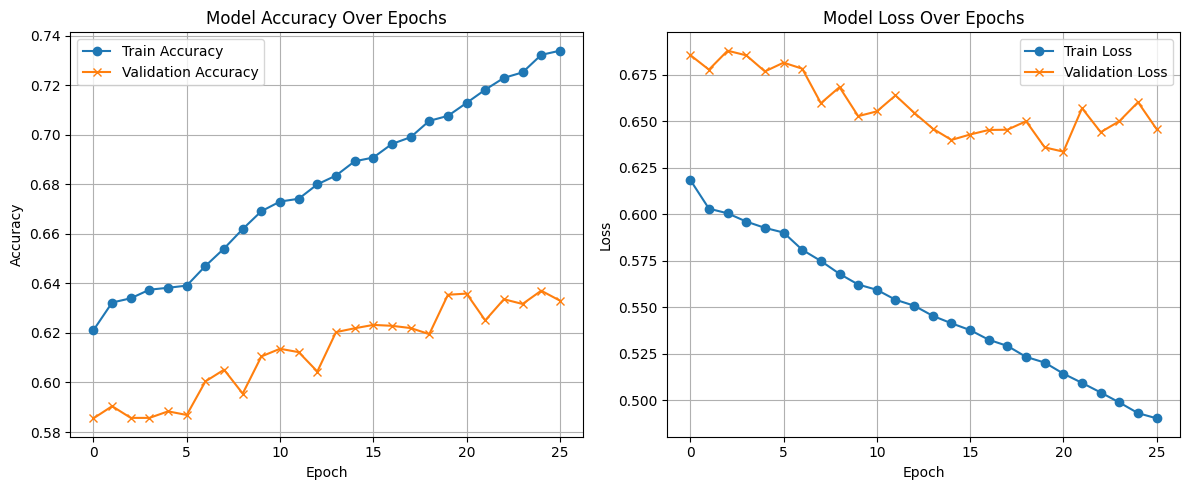

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Here in the plots we can see that the **Traning Accuracy** and **Validation Accuracy** both are increasing, so we can infer that the model is leanrning something useful.

We can also confirm this by the continuously decreasing **Train Loss** and **Validation Loss**

In [29]:
from sklearn.metrics import classification_report

y_pred_probs=model.predict([X_ref_test, X_alt_test])
y_pred=(y_pred_probs > 0.5).astype(int)
print(classification_report(y_test,y_pred))


344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
              precision    recall  f1-score   support

           0       0.71      0.74      0.73      6450
           1       0.61      0.58      0.59      4554

    accuracy                           0.67     11004
   macro avg       0.66      0.66      0.66     11004
weighted avg       0.67      0.67      0.67     11004



The model shows moderate performance for class 1 (Pathogenic variants) in terms of precision and recall. While the results are acceptable for a first attempt, there's still room for improvement especially considering the biological importance of correctly identifying pathogenic SNPs.

However, it's important to note that the test data remains imbalanced, with significantly more benign samples than pathogenic ones. In such cases, metrics like accuracy can be misleading, and even precision and recall may not fully reflect model performance.

In [66]:
pd.Series(y_test).value_counts()

,count
ClinSigSimple,
0,6450
1,4554


344/344 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


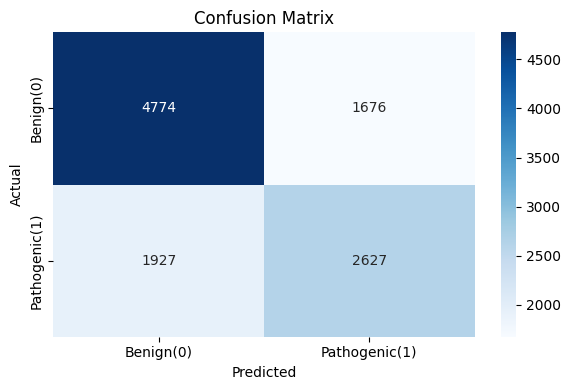

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs=model.predict([X_ref_test,X_alt_test])
y_pred=(y_pred_probs>0.5).astype(int)

# Confusion Matrix
cm=confusion_matrix(y_test, y_pred)

# Plotting Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',
            xticklabels=['Benign(0)','Pathogenic(1)'],
            yticklabels=['Benign(0)','Pathogenic(1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


Here in the confusion matrix we can see that the model can confidenetly clasify Bening as bening but is less confident in case of Pathogenic Variants.

Basically here in Medical AI we can excuse some **False Positive** but we cannot excuse **False Negetive**. So we need to minimize the number of False Negetives.

So basically we need to increase the **Recall** even if the **Precision** slightly drops.

So I have done some threshold tunig using Precision-Recall Curve.

**I have specifically not used ROC for threshold tuning because in case of imbalanced test data the ROC can be slighly misleading because due to leage number of True Negtives the FPR will be very low even though the number of False Positive is very high. So slightly increasing the FPR can also increase the number of False Positives very much.**

344/344 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step


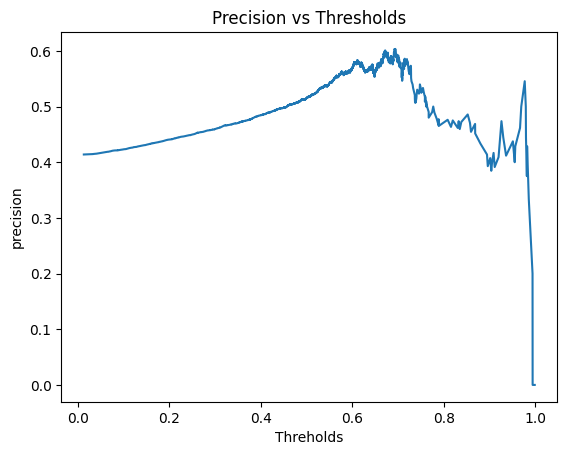

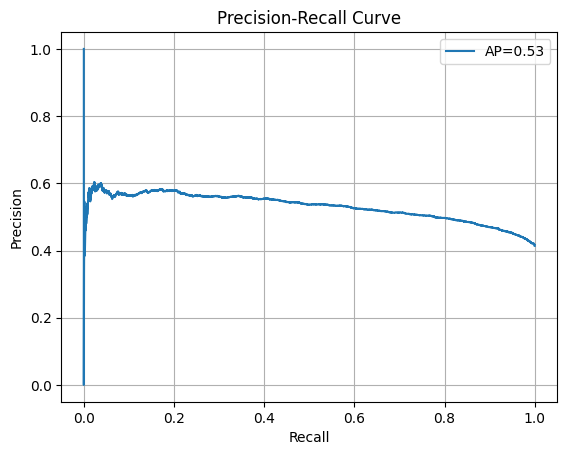

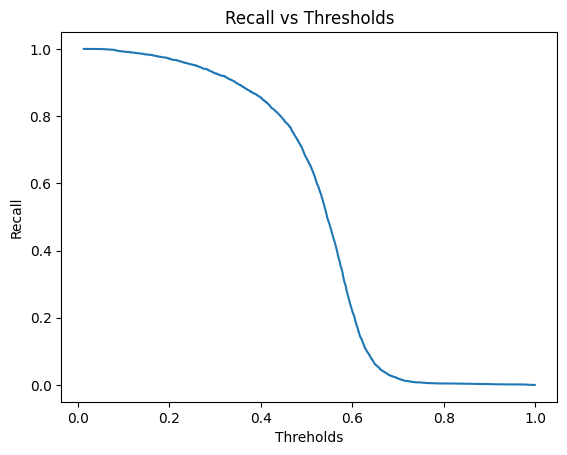

Best Threshold(based on best F1 score): 0.39224458


In [67]:
from sklearn.metrics import precision_recall_curve,average_precision_score
import matplotlib.pyplot as plt

y_scores=model.predict([X_ref_test,X_alt_test])

precision,recall,thresholds=precision_recall_curve(y_test,y_scores)

plt.plot(thresholds,precision[:-1],label='Precision')
average_precision=average_precision_score(y_test,y_scores)

plt.title("Precision vs Thresholds")
plt.xlabel("Threholds")
plt.ylabel('precision')
plt.show()

plt.plot(recall,precision,label=f'AP={average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

plt.plot(thresholds,recall[:-1],label='Recall')
plt.title("Recall vs Thresholds")
plt.xlabel("Threholds")
plt.ylabel('Recall')
plt.show()


f1_score=[]
for i in range(len(thresholds)):
  f1_score.append(2*precision[i]*recall[i]/(precision[i]+recall[i]+(10**-10)))

max_index=f1_score.index(max(f1_score))
best_threshold=thresholds[max_index]
print("Best Threshold(based on best F1 score):",best_threshold)



Here in the Precision vs Threshold curve we can see that the precision is maximum near the threshold of approx 0.7.

But we need to prioritise Recall more than Precision as **False Negetives** are more costly than **False Positives**

**So I have plotted the Precision vs Recall curve and with the help of F1 score we can see that the best threshold for th best F1 score is 0.37.
So at the threshold the Precision and Recall is balanced as it has the highest F1 acotre among all other Precision and Recall combinations**.

**And besides that we also have to increase the recall more so need to shift the threshod to somehwat less than 0.37 to increase the recall(as we can see fromt he recall vs threshold plot) but it also decreases preicison but we can excuse slight decrease in precision.**

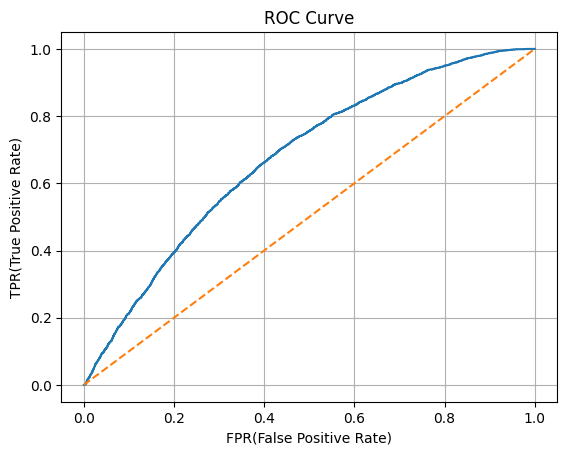

Threholds array: [       inf 0.99988556 0.99482614 ... 0.03420502 0.03406034 0.00744983]
AUC Score: 0.6760528375957924
Best Threshold: 0.46059456


In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve

fpr,tpr,thresholds=roc_curve(y_test,y_scores)
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel("FPR(False Positive Rate)")
plt.ylabel("TPR(True Positive Rate)")
plt.title("ROC Curve")
plt.grid()
plt.show()
roc_auc=roc_auc_score(y_test,y_scores)
auc_score=roc_auc_score(y_test,y_scores)

print("Threholds array:",thresholds)
print("AUC Score:",auc_score)

dist=[]
for i in range(len(thresholds)):
  dist.append(((fpr[i]-0)**2+(tpr[i]-1)**2)**0.5)

min_index=dist.index(min(dist))
best_threshold=thresholds[min_index]
print("Best Threshold:",best_threshold)


**We can also see from the ROC-AUC of 0.67 that the model is able to distinguish between Pathogenic and Bening SNPs.**

**Though ROC-AUC is not good to be used for imbalanced data but then also it can give us some insights.**

# **Custom SmoothGrad Interpretibility**

In [23]:
from tensorflow.keras.models import load_model
model=load_model('model (2).h5')

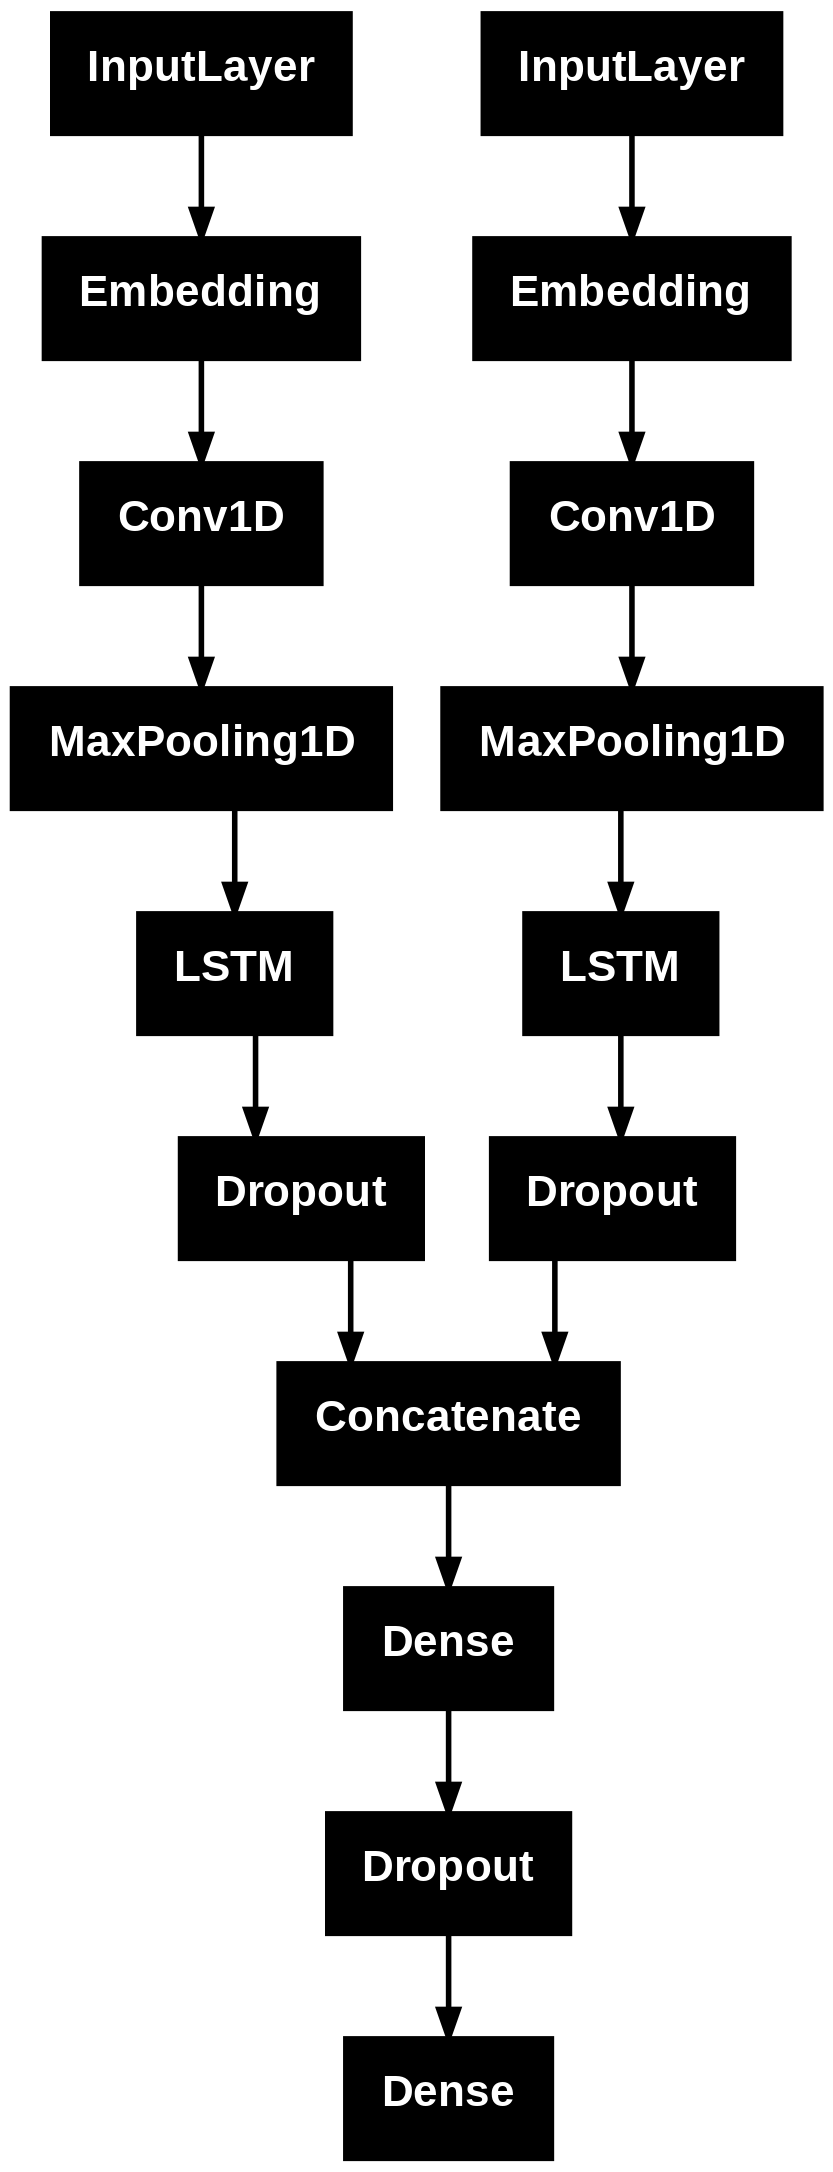

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [25]:
print(X_ref_test.shape)

(11004, 150)


Printing Layer Name with its index for Functional API in Keras

In [51]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.__class__.__name__)

0 input_layer InputLayer
1 input_layer_1 InputLayer
2 embedding Embedding
3 embedding_1 Embedding
4 conv1d Conv1D
5 conv1d_1 Conv1D
6 max_pooling1d MaxPooling1D
7 max_pooling1d_1 MaxPooling1D
8 lstm LSTM
9 lstm_1 LSTM
10 dropout Dropout
11 dropout_1 Dropout
12 concatenate Concatenate
13 dense Dense
14 dropout_2 Dropout
15 dense_1 Dense


To create a interpretibility I have created a custom pipeline for SmoothGrad for 1D Genomic Sequences as SmoothGrad is mainly used for Images but it an also be used for 1D Genomic Sequences.

And I have created the importance plot wrt the base position for both the *Reference Sequence* and the *Alternate Sequence*

[1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 

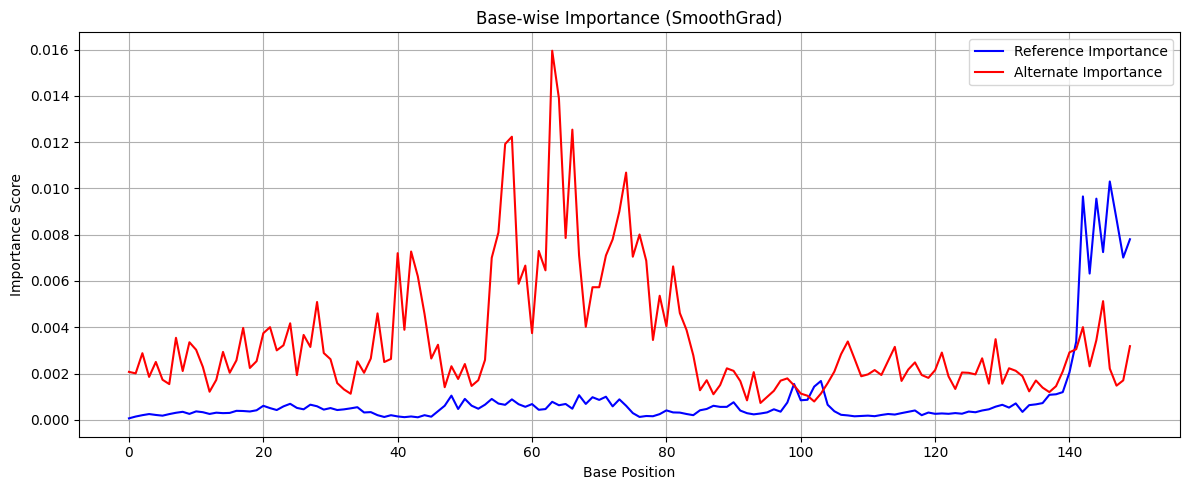

In [ ]:
y_pred=[]
for i in y_scores:
  if i>0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)
print(y_pred)





# Interpretability Inplementation

import tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)

print(X_ref_test[0,:].shape)

X_ref_tensor=tf.convert_to_tensor(X_ref_test[0,:].reshape(1,150),tf.float32)
X_alt_tensor=tf.convert_to_tensor(X_alt_test[0,:].reshape(1,150),tf.float32)

print(X_ref_tensor.shape)

smooth_grads_ref=[]
smooth_grads_alt=[]

# model_body
input_emb_ref=tf.keras.Input(shape=(150,32))
input_emb_alt=tf.keras.Input(shape=(150,32))
#Conv1D layers
x_ref=model.layers[4](input_emb_ref)
x_alt=model.layers[5](input_emb_alt)
# Maxpoling layers
x_ref=model.layers[6](x_ref)
x_alt=model.layers[7](x_alt)
#LSTM Layers
x_ref=model.layers[8](x_ref)
x_alt=model.layers[9](x_alt)
# Droupout Layers
x_ref=model.layers[10](x_ref)
x_alt=model.layers[11](x_alt)
#Merge
x=model.layers[12]([x_ref,x_alt])
#Dense Layers
x=model.layers[13](x)
x=model.layers[14](x)
x=model.layers[15](x)

model_body=tf.keras.Model(inputs=[input_emb_ref,input_emb_alt],outputs=x)

for i in range(50):
  noise_ref=tf.random.normal(shape=X_ref_tensor.shape,stddev=0.3)
  noise_alt=tf.random.normal(shape=X_alt_tensor.shape,stddev=0.2)

  noisy_ref_tensor=X_ref_tensor+noise_ref
  noisy_alt_tensor=X_alt_tensor+noise_alt

  noisy_ref_tensor=tf.clip_by_value(noisy_ref_tensor,0,4)
  noisy_ref_tensor=tf.round(noisy_ref_tensor)
  noisy_ref_tensor=tf.cast(noisy_ref_tensor,tf.float32)

  noisy_alt_tensor=tf.clip_by_value(noisy_alt_tensor,0,4)
  noisy_alt_tensor=tf.round(noisy_alt_tensor)
  noisy_alt_tensor=tf.cast(noisy_alt_tensor,tf.float32)

  embedding_layer_ref=model.layers[2]
  embedding_layer_alt=model.layers[3]

  with tf.GradientTape(persistent=True) as tape:
    emb_ref=embedding_layer_ref(noisy_ref_tensor)
    emb_alt=embedding_layer_alt(noisy_alt_tensor)

    tape.watch(emb_ref)
    tape.watch(emb_alt)

    prediction=model_body([emb_ref,emb_alt])
    loss=prediction[0,0]

  gradients_ref=tape.gradient(loss,emb_ref)
  gradients_alt=tape.gradient(loss,emb_alt)

  del tape

  smooth_grads_ref.append(gradients_ref)
  smooth_grads_alt.append(gradients_alt)

smooth_grads_ref=np.array(smooth_grads_ref)
smooth_grads_alt=np.array(smooth_grads_alt)

smooth_grads_ref=smooth_grads_ref.reshape(50,150,32)   # Converting (50,1,150,32) to (50,150,,32) as we don't need the batch size number now
smooth_grads_alt=smooth_grads_alt.reshape(50,150,32)

print(smooth_grads_ref.shape)
print(smooth_grads_alt.shape)

avg_grad_ref=np.mean(np.abs(smooth_grads_ref),axis=0)
avg_grad_alt=np.mean(np.abs(smooth_grads_alt),axis=0)

print(avg_grad_ref.shape)
print(avg_grad_alt.shape)

importance_ref=np.mean(avg_grad_ref,axis=1)
importance_alt=np.mean(avg_grad_alt,axis=1)

print(importance_ref.shape)
print(importance_alt.shape)


**We can clearly see in the importance plot that at nearly 75th base position the importance is maximum where I have placed the SNP during feature engineering.**

**So it can basically capture the patterns and understand the different position.**

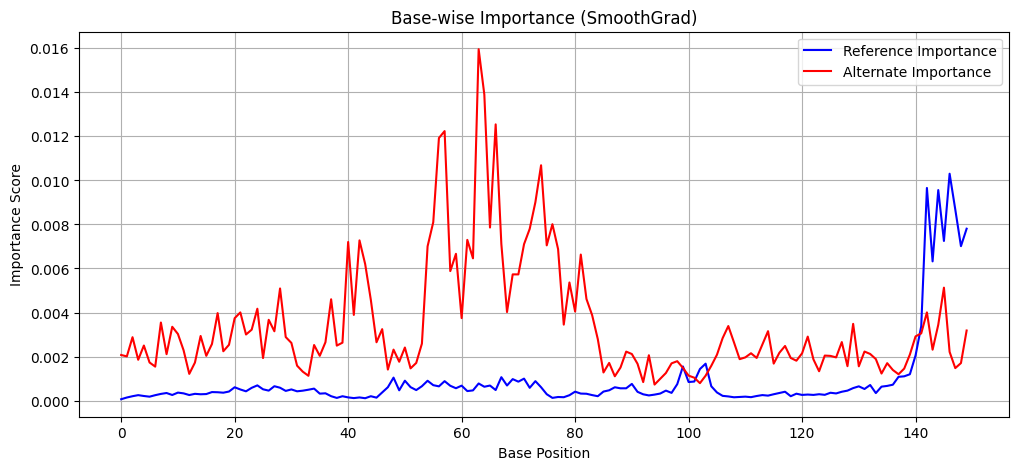

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(importance_ref,label='Reference Importance',color='blue')
plt.plot(importance_alt, label='Alternate Importance',color='red')
plt.xlabel("Base Position")
plt.ylabel("Importance Score")
plt.title("Base-wise Importance (SmoothGrad)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save("model.h5")